In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))
from utils import read_filenames, prepare_datasets

In [15]:
path = '/Users/michal/Documents/studia/sem4/WdUM/Galaxies_Clusterization/data/images'

galaxies = read_filenames(path)
galaxies_train, galaxies_val, galaxies_test = prepare_datasets(galaxies, 100000)

### Loading feature vectors created in processing stage

In [3]:
x = np.load('../processing/feature_vectors.npy')

In [4]:
x.shape

(1000, 100)

### Determining the number of clusters for Kmeans

In [6]:
def count_wcss_scores(X, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

Within-cluster sum of squares method

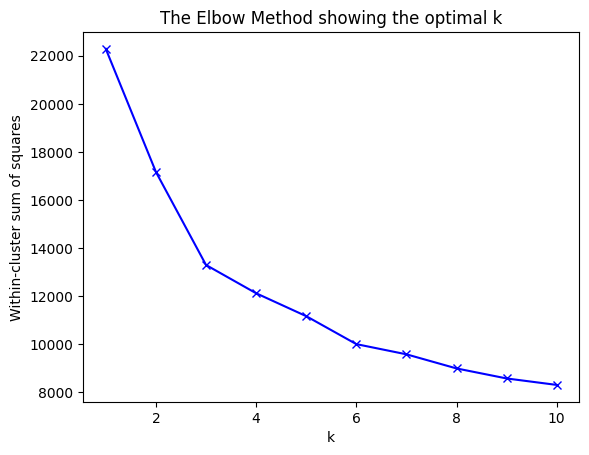

In [9]:
wcss_vec = count_wcss_scores(x, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Eblow at 6 clusters (?)

Silhouette method

In [10]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

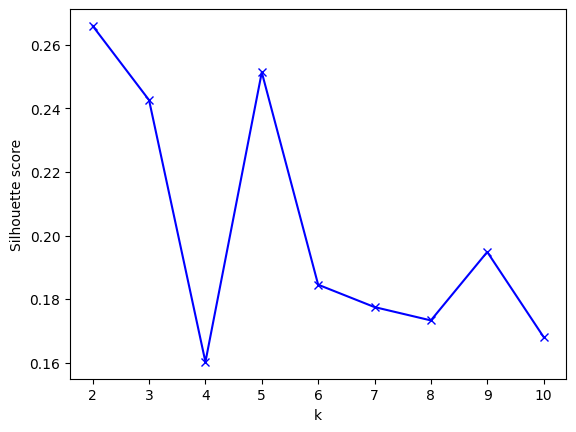

In [12]:
cluster_num_seq = range(2, 11) # Niektóre metryki nie działają gdy mamy tylko jeden klaster
silhouette_vec = count_clustering_scores(x, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Silhoutte score is maximized at k = 5, lets try 5 clusters.

In [13]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(x)

KMeans(n_clusters=5, random_state=42)

In [21]:
groups = {} # cluster_id : images
for file, cluster in zip(galaxies_train[:len(x)], kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

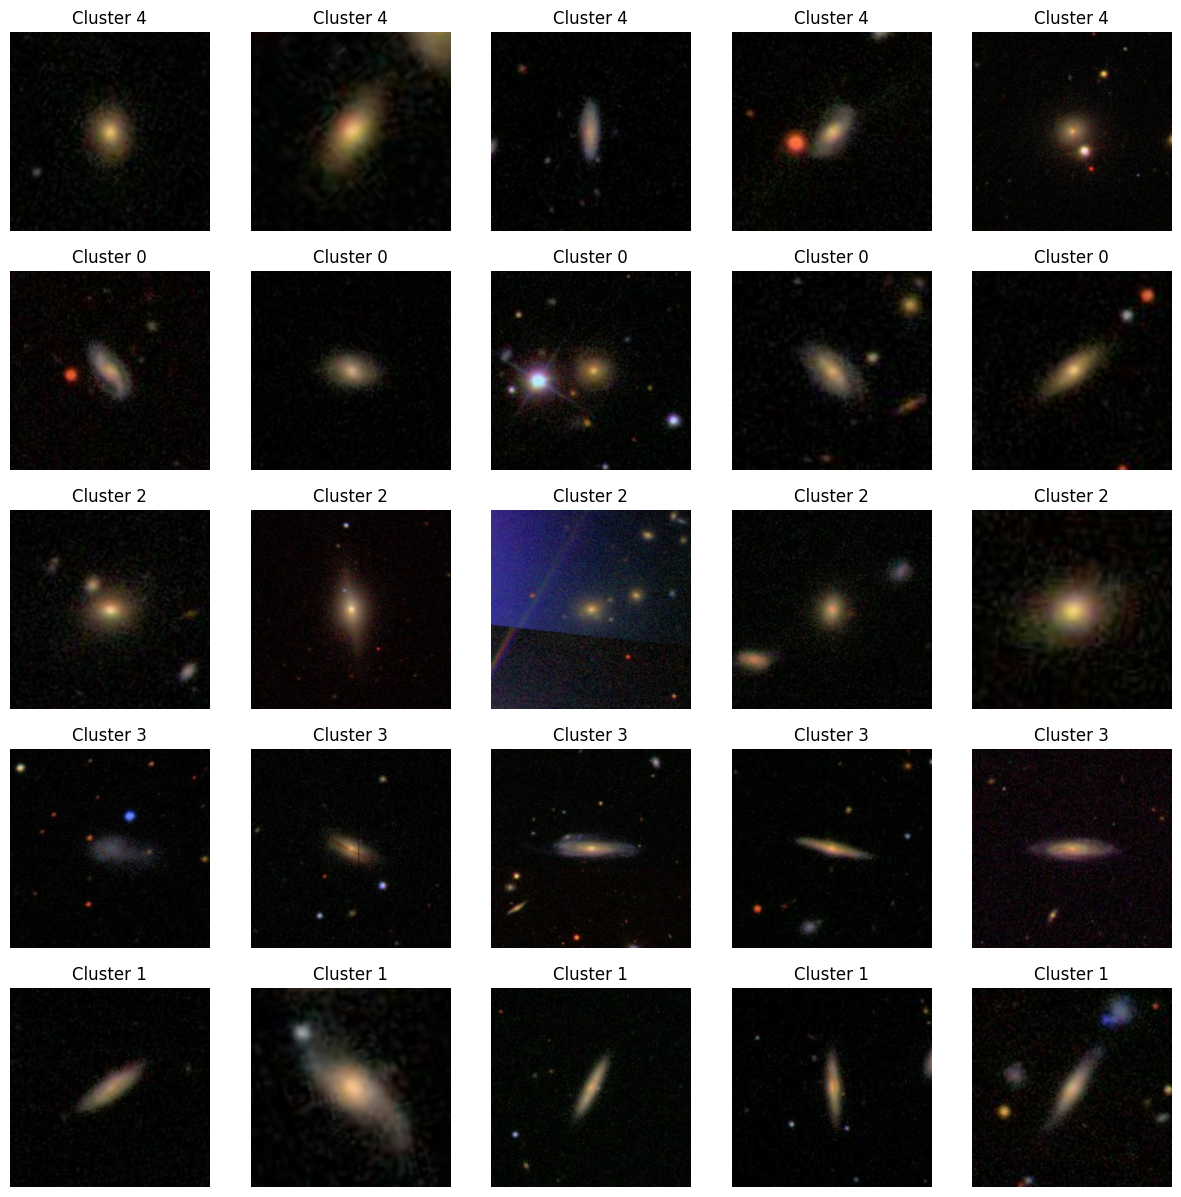

In [25]:
n = 5
fig, axs = plt.subplots(len(groups), n, figsize=(15, 15))

for i, cluster in enumerate(groups.keys()):
    for j in range(n):
        filename = f'../data/images/{groups[cluster][j+5]}'
        img = plt.imread(filename)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Cluster {cluster}")
plt.show()